<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03-Deep-Learning/notebooks/07-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Long Short-Term Memory Networks: Time Series</h1>

En esta notebook usaremos redes LSTM, el cual es una de las arquitectura de red RNN más usadas. Usaremos una red LSTM para predecir series de tiempo. Estudiaremos el problema de predecir el número de pasajeros en diferentes meses usanndo la información de periodos de tiempo anteriores. Es un problema de **regresión**.

Describiremos diferentes modelos basados en LSTM y compararemos sus desempeños.


<img align="left" width="50%" src="../img/LSTM.png"/>

In [54]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error

# Primer método

## El conjunto de datos

Usaremos un conjunto de datos para predecir el número de pasajeros de líneas aéreas internacionales. Se trata de un problema en el que, dados un año y un mes, la tarea consiste en predecir el número de pasajeros de líneas aéreas internacionales en unidades de 1.000. Los datos van de enero de 1949 a diciembre de 1960, es decir, 12 años, con 144 observaciones. El conjunto original de datos se puede encontrar [aquí](https://www.kaggle.com/datasets/rakannimer/air-passengers).

In [ ]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03-Deep-Learning/data/AirPassengers.csv"
!wget --no-cache --backups=1 {url}

Leemos el dataframe

In [ ]:
import pandas as pd

np.random.seed(7)

dataframe = pd.read_csv('AirPassengers.csv')
display(dataframe)

Visualizamos los datos

In [ ]:
# ----- Cambiamos el índice del dataframe por la fecha de la observación -----
dataframe.columns = ['Date', 'Passengers']
dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%Y-%m')
dataframe = dataframe.set_index('Date')
dataframe.head()

plt.plot(dataframe, color='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

Nos quedamos con la serie de valores del dataframe

In [ ]:
dataset = dataframe.values
dataset = dataset.astype('float32')
print(f"Serie de tiempo: {dataset[:3].reshape(-1,)} ... {dataset[-4:].reshape(-1,)}")

## Preprocesamiento de los datos

Necesitamos generar los conjunto $X$, $Y$ para la red LSTM. El conjunto $X$ es el conjunto que ya tenemos de datos de la serie de tiempo. El conjunto $y$ es la misma serie de tiempo, *adelantada* $l_b=1$ observación. Es decir, si la serie de tiempo esta dada por $x_0,x_1,...,x_n$, tendremos:

$$X = (x_0,x_1,...,x_{n-2})$$
$$Y = (x_1,x_2,...,x_{n-1})$$

Podemos variar el parámetro $l_b$ (look back). **Ahorita no lo haremos, sino hasta el final del ejemplo**

Definimos una función que genere los arreglos $X$, $Y$.

In [60]:
def create_dataset(x, look_back=1):
	dataX, dataY = [], []
	for i in range(len(x)-look_back-1):
		a = x[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(x[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

Veamos como quedarían los datos. **Regresaremos a probar con varios valores de *look_back* $l_b$ al final del ejercicio, por ahora, nos quedamos con $l_b=1$.**

In [61]:
look_back = 2

In [ ]:
print(f"Tamaño de la serie inicial: {dataset.shape[0]}")
print(f"Serie de tiempo original: {dataset[:3].reshape(-1,)} ... {dataset[-4:].reshape(-1,)}")

X, y = create_dataset(dataset,look_back)

print(X.shape, y.shape)

if lb==1:
    print(f"\nTamaño de las series para la LSTM: {X.shape[0]}")
    print(f"Serie de tiempo modificada X: {X[:3].reshape(-1,)} ... {X[-3:].reshape(-1,)}")
    print(f"Serie de tiempo modificada Y: {y[:3].reshape(-1,)} ... {y[-3:].reshape(-1,)}")
else:
    print(f"\nTamaño de las series para la LSTM: {X.shape}")
    print(f"Serie de tiempo modificada X:\n {X[:3]}")
    print(f"Serie de tiempo modificada Y: {y[:3]}")

Re-escalamos los datos para que queden en el intervalo $[0,1]$.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset[:5]

Dividimos en entrenamiento y prueba. Observar que los datos deben ser divididos en forma *ordenada*, es decir:

$$X_{train} = \{ x_0, ... , x_k\} $$
$$X_{test} = \{ x_{k+1}, ... , x_n\} $$

In [ ]:
train_ratio = 0.7

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# ----- Generamos los conjuntos X,Y de entrenamiento y prueba -----
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

# ----- reshape input to be [samples, time steps, features] -----
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

## Definimos y entrenamos el modelo

La célula de LSTM se encuentra implementada en [Keras](https://keras.io/api/layers/recurrent_layers/lstm/) como `LSTM`. Algunos de los parámetros importantes son:

* `units`: Positive integer, dimensionality of the output space. En este ejemplo, el valor es 4.
* `activation`: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
* `recurrent_activation`: Activation function to use for the recurrent step. Default: sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).

In [65]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [66]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# ------ Creamos el modelo ------
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

# ------ Compilamos el modelo ------
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

**¿Cómo podemos combinar capas LSTM?**

Es posible apilar capas LSTM en arquitecturas de redes profundas para entrenarse juntas, compartiendo la memoría entre ellas.

Las capas LSTM pueden apilarse en Keras de la misma manera que otros tipos de capas. El requisito para hacerlo es que la primer capa devuelva la secuencia para que sea recibida por la segunda capa. Esto se puede hacer estableciendo el parámetro `return_sequence` como *True*.

In [67]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM

# # ------ Creamos el modelo ------
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)),return_sequence=True)
# model.add(LSTM(4))
# model.add(Dense(1))

# # ------ Compilamos el modelo ------
# model.compile(loss='mean_squared_error', optimizer='adam')

Entrenamos el modelo

In [ ]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2,
                    validation_split=0.1,callbacks=[es])

## Obtenemos las predicciones y evaluamos el desempeño de la red

In [ ]:
plt.figure(figsize=(5, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Realizamos las predicciones

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Aplicamos la transformación inversa del escalador, para obtener los valores en su escala original.

In [71]:
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

Calculamos el error en las predicciones. Al ser un problema de regresión, usamos una pérdida y métrica de regresión: RMSE, MSE, MAE, etc.

Podemos evaluar para ver el MAE y RMSE

In [ ]:
print(model.evaluate(X_train, Y_train.reshape(-1,)))
print(model.evaluate(X_test, Y_test.reshape(-1,)))

In [ ]:
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score RMSE: %.2f' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score RMSE: %.2f' % (test_score))

Graficamos las predicciones, tanto en train como en test

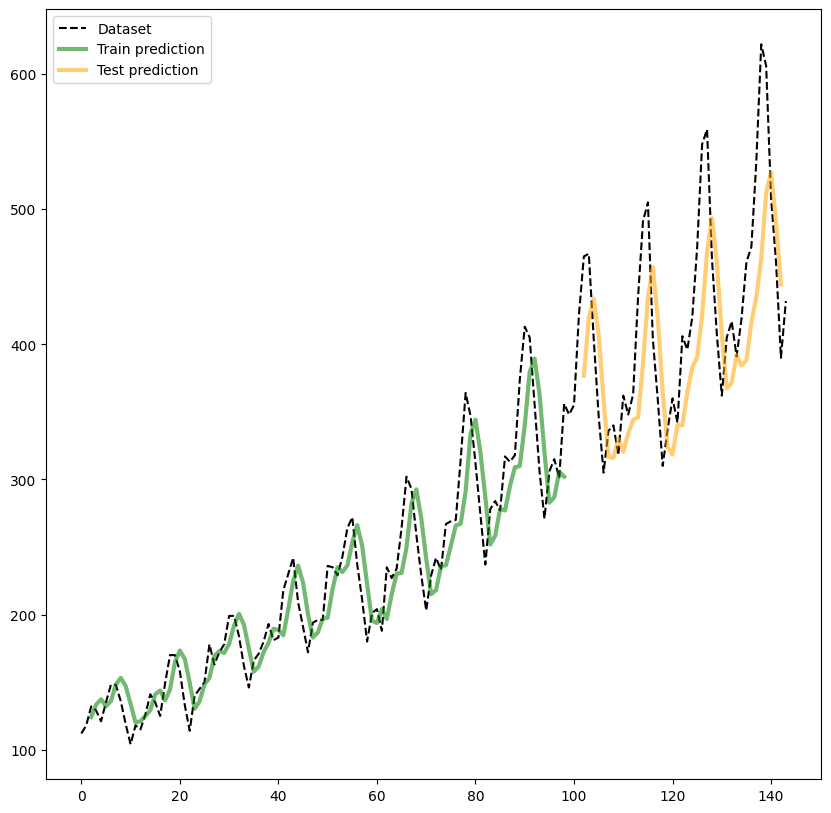

In [74]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(dataset),label='Dataset',linestyle='--',color='black')
plt.plot(trainPredictPlot,label='Train prediction',color='green',linewidth=3,alpha=0.55)
plt.plot(testPredictPlot,label='Test prediction',color='orange',linewidth=3,alpha=0.55)
plt.legend(loc='best')
plt.show()

## Una arquitectura más compleja

Probemos con una arquitectura más profunda. Observar que las capas LSTM regresan las secuencias, de esta forma, se entrenan juntas y comparten la memoria.

Juntamos todo el preprocesamiento en una misma celda

In [ ]:
train_ratio = 0.7

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# ----- Generamos los conjuntos X,Y -----
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# ----- reshape input to be [samples, time steps, features] -----
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

model_3 = Sequential()
model_3.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model_3.add(Dropout(0.2))
model_3.add(LSTM(80, return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(50, return_sequences=True))
model_3.add(Dropout(0.2))
model_3.add(LSTM(30, activation="ReLU"))
model_3.add(Dense(1))

model_3.summary()

model_3.compile(loss='mean_squared_error', optimizer='adam')

In [77]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Entrenamos el modelo

In [ ]:
history = model_3.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2,
                    validation_split=0.1,callbacks=[es])

In [ ]:
plt.figure(figsize=(5, 5),dpi=100)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Hacemos las predicciones

In [ ]:
trainPredict = model_3.predict(X_train)
testPredict = model_3.predict(X_test)

Invertimos las predicciones (des-escalamos)

In [81]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
Y_train = scaler.inverse_transform([Y_train])
testPredict = scaler.inverse_transform(testPredict)
Y_test = scaler.inverse_transform([Y_test])

Obtenemos las métricas de evaluación

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(Y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(dataset),label='Dataset',linestyle='--',color='black')
plt.plot(trainPredictPlot,label='Train prediction',color='green',linewidth=3,alpha=0.55)
plt.plot(testPredictPlot,label='Test prediction',color='orange',linewidth=3,alpha=0.55)
plt.legend(loc='best')
plt.show()

In [ ]:
print(model.evaluate(X_train, Y_train.reshape(-1,)))
print(model.evaluate(X_test, Y_test.reshape(-1,)))

# Window Method

Otra manera de plantear el probemas es considerar que varios datos previos pueden ser usado para predecir el siguiente dato de una serie de tiempo.

A estos multiples valores pasdos se les llama *ventana*, el tamaño de la ventana puede variarse y depende del problema.

Por ejemplo, dado el tiempo actual $t$ queremos predecir el valor en el siguiente tiempo de la secuencia $t+1$, podemos utilizar el tiempo actual (t), así como los dos tiempos anteriores $t-1$ y $t-2$ como variables de entrada.

Si se plantea como un problema de regresión, las variables de entrada son $t-2$, $t-1$, $t$ y la variable de salida es $t+1$.

Es decir, si la serie de tiempo esta dada por $x_0,x_1,...,x_n$, tendremos:

\begin{align}
X =
\begin{pmatrix}
    x_0 & x_1 & x_2 \\
    x_1 & x_2 & x_3 \\
     & ... & \\
    x_{n-3} & x_{n-2} & x_{n-1}
    \end{pmatrix}
\end{align}

\begin{align}
Y =
\begin{pmatrix}
    x_3 \\
    x_4 \\
    ...\\
    x_n
    \end{pmatrix}
\end{align}
    
Esto lo logramos variando el parámetro *look back* de la función de construcción de los datos. Experimenta con este valor y verifica que los datos tienen la forma dada por las expresiones anteriores.

⭕ Ejercicio:
* Encuentra un valor para el $l_p$ que mejore el desempeño de la LSTM anterior. Recuerda que, al ser un problema de regresión, lo que estamos tratando de minimizar es la función de perdida.
* Puedes usar también capas de dropout y callbacks.


---


Hay varios técnicas más para LSTM, por ejemplo:

* **Diferenciación de datos.** Los datos estacionarios son más fáciles de modelar. Este tipo de datos no tiene una estructura que dependa del tiempo. En el caso de los conjuntos de datos no estacionarios, por ejemplo, si los datos tienen una tendencia creciente, la tendencia puede eliminarse de las observaciones y volver a añadirse a las previsiones más adelante para devolver la predicción a la escala original. Una forma estándar de eliminar una tendencia es diferenciar los datos.
    
    **Esto no lo haremos ahora**